In [1]:
from prep_data import PrepData
from anchor_boxes import *
from yolo_model import *
from predicting import *

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json

In [2]:
input_shape = (676, 380, 3)
grid_dim = 13
anchor_sizes = [(0.15, 0.075), (0.2, 0.1), (0.3, 0.2)] # The widths are longer because we detect cars
num_anchors = len(anchor_sizes)

In [3]:
p = PrepData()
train, test = p.load_images()
labels = p.connect_labels(train, grid_dim, anchor_sizes, iou_vectorized)
train, test = p.preprocess_images(train), p.preprocess_images(test)

# swap axes of x and y of the image
train = np.swapaxes(train, 1, 2)
test = np.swapaxes(test, 1, 2)
train.shape

[0.4345152  0.55654762 0.19464544 0.13384813 1.        ]


(1001, 676, 380, 3)

In [6]:
def equalize_box_labels(y_true, y_pred):
    # Masks for boxes with and without objects in y_true
    object_mask = tf.reduce_max(y_true, axis=-1) > 0
    no_object_mask = tf.reduce_max(y_true, axis=-1) == 0
    
    # Filter boxes with and without objects
    true_boxes_with_obj = tf.boolean_mask(y_true, object_mask)
    pred_boxes_with_obj = tf.boolean_mask(y_pred, object_mask)
    
    # Randomly sample no_object boxes to equal the number of object boxes, if possible
    no_object_indices = tf.where(no_object_mask)
    sampled_no_object_indices = tf.random.shuffle(no_object_indices)[:tf.shape(true_boxes_with_obj)[0]]
    
    # Fetch the corresponding no_object boxes
    true_boxes_no_obj = tf.gather_nd(y_true, sampled_no_object_indices)
    pred_boxes_no_obj = tf.gather_nd(y_pred, sampled_no_object_indices)
    
    # Concatenate to have a balanced set
    true_boxes_equalized = tf.concat([true_boxes_with_obj, true_boxes_no_obj], axis=0)
    pred_boxes_equalized = tf.concat([pred_boxes_with_obj, pred_boxes_no_obj], axis=0)
    
    return true_boxes_equalized, pred_boxes_equalized

def custom_iou_loss(y_true, y_pred):
    y_true, y_pred = equalize_box_labels(y_true, y_pred)
    
    # Compute IOUs
    ious = iou_vectorized(y_true[..., :4], y_pred[..., :4])
    iou_loss = tf.abs(ious - y_true[..., -1]) # IOU losses - the confidence scores
    
    # Mean squared error over IOU losses
    return tf.reduce_mean(tf.square(iou_loss))

def custom_iou_metric(y_true, y_pred):
    ious = iou_vectorized(y_true[..., :4], y_pred[..., :4])
    return tf.reduce_mean(ious)

In [7]:
model = yolo_model(input_shape, grid_dim, num_anchors)

adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_opt, loss=custom_iou_loss, metrics=['accuracy', custom_iou_metric])
model.fit(train, labels, epochs=1, batch_size=16, verbose=1)

/Users/jadenvanrijswijk/Code/Car Pose Estimation/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


46/63 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0620 - custom_iou_metric: 2.1145e-05 - loss: 1.7200e-04

KeyboardInterrupt: 

In [28]:
# Save the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")

Model saved to disk


In [6]:
# Load the model
json_file = open('./model/model.json', 'r') 
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'custom_iou_loss': custom_iou_loss, 'custom_iou_metric': custom_iou_metric})
model.load_weights("./model/model.weights.h5") # set weights

In [66]:
image = test[0]
image = predict_image(image, model, grid_dim, anchor_sizes, iou_vectorized)
image = np.swapaxes(image, 0, 1)

#Show the image with matplotlib
plt.imshow(image)
plt.show()

NameError: name 'model' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


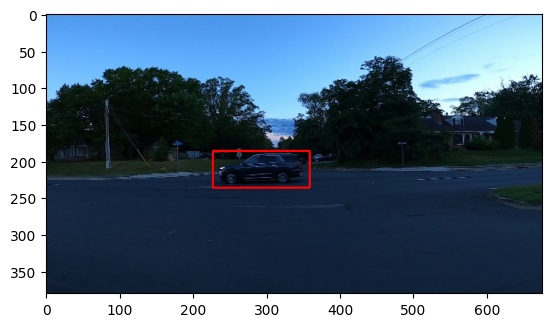

In [67]:
image = train[0].copy()  # Create a copy of the image to avoid modifying the original data
label = labels[0]

coords = labels_to_coordinates(label, image.shape[0], image.shape[1], grid_dim)
image = draw_boxes(image, coords)

image = np.swapaxes(image, 0, 1)

#Show the image with matplotlib
plt.imshow(image)
plt.show()